In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib

In [24]:
%matplotlib inline

# Load Dataset from Google Drive

In [43]:
# Load dataset
train_data = pd.read_excel("Data_Train.xlsx")  # Ensure the correct file path


In [44]:
# Display first few rows
display(train_data.head())

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [46]:
# Preprocess data (Example: handling missing values and encoding categorical variables)
train_data.fillna(train_data.select_dtypes(include=[np.number]).mean(), inplace=True)
train_data = pd.get_dummies(train_data, drop_first=True)

In [47]:
# Splitting features and target variable (Assuming 'Price' is the column to predict)
X = train_data.drop(columns=['Price'])
y = train_data['Price']

In [48]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
print(X_train.shape, y_train.shape)


(8546, 2133) (8546,)


In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [49]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [50]:
# Initialize and train SGDRegressor with warm_start=True
lin_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True, learning_rate='constant', eta0=0.01)
loss_curve = []

In [51]:
for i in range(100):  # 100 iterations
    lin_reg.partial_fit(X_train, y_train)
    y_pred = lin_reg.predict(X_train)
    loss = mean_squared_error(y_train, y_pred)
    loss_curve.append(loss)

In [52]:
# Evaluate model
y_test_pred = lin_reg.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

In [53]:
print(f"Test MSE: {mse:.4f}")
print(f"Test R^2 Score: {r2:.4f}")

Test MSE: 250034458604891201276477440.0000
Test R^2 Score: -11814158931604695040.0000


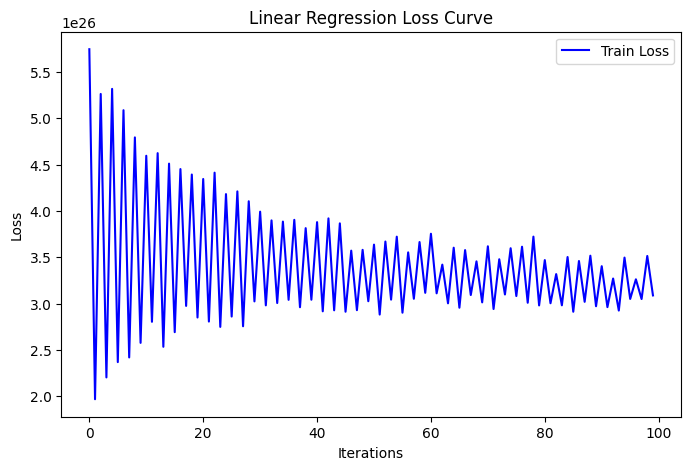

In [54]:
# Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(loss_curve, label='Train Loss', color='blue')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Linear Regression Loss Curve")
plt.legend()
plt.show()

In [55]:
# Train and evaluate other models
models = {
    "Linear Regression (SGD)": lin_reg,
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor()
}

In [56]:
results = []
for name, model in models.items():
    if name != "Linear Regression (SGD)":
        model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    results.append({"Model": name, "MSE": mse, "R² Score": r2})

In [57]:
# Convert results into a DataFrame
results_df = pd.DataFrame(results)

In [58]:
# Display the comparison table
display(results_df)

,Model,MSE,R² Score
0,Linear Regression (SGD),2.500345e+26,-1.181416e+19
1,Decision Tree,2.489351e+06,8.823779e-01
2,Random Forest,2.177164e+06,8.971287e-01


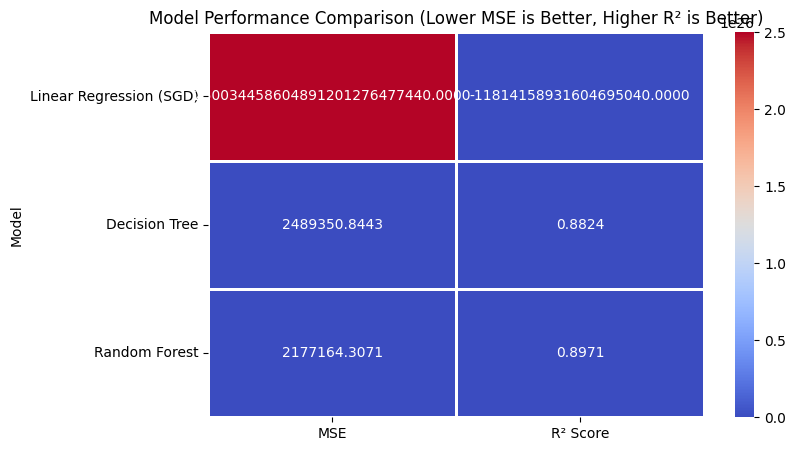

In [59]:
# Create a heatmap for MSE & R² Score
plt.figure(figsize=(8, 5))
sns.heatmap(results_df.set_index("Model"), annot=True, fmt=".4f", cmap="coolwarm", linewidths=1)
plt.title("Model Performance Comparison (Lower MSE is Better, Higher R² is Better)")
plt.show()

In [41]:
# Save best model
joblib.dump(lin_reg, "best_model.pkl")

['best_model.pkl']

In [67]:
import pandas as pd
import joblib
import re
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

# Load datasets
df = pd.read_excel("Data_Train.xlsx")

# Drop null values and unnecessary columns
df.dropna(inplace=True)
df.drop(columns=["Route", "Additional_Info", "Date_of_Journey"], inplace=True)

# Convert Duration column to total minutes
def convert_duration(duration):
    """Convert '2h 50m' into total minutes (170)."""
    hours = re.search(r'(\d+)h', duration)
    minutes = re.search(r'(\d+)m', duration)
    total_minutes = (int(hours.group(1)) * 60 if hours else 0) + (int(minutes.group(1)) if minutes else 0)
    return total_minutes

df["Duration"] = df["Duration"].apply(convert_duration)

# Convert 'Total_Stops' column to numerical format
stops_mapping = {"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}
df["Total_Stops"] = df["Total_Stops"].map(stops_mapping)

# Define categorical and numerical columns
categorical_cols = ["Airline", "Source", "Destination"]
numerical_cols = ["Duration", "Total_Stops"]

# Fit transformers
encoder = OneHotEncoder(handle_unknown="ignore")
scaler = StandardScaler()

encoder.fit(df[categorical_cols])
scaler.fit(df[numerical_cols])

# Save transformers to avoid refitting
joblib.dump(encoder, "encoder.pkl")
joblib.dump(scaler, "scaler.pkl")

# Train the model
X_cat = encoder.transform(df[categorical_cols]).toarray()
X_num = scaler.transform(df[numerical_cols])
X_train = pd.concat([pd.DataFrame(X_cat), pd.DataFrame(X_num)], axis=1)
y_train = df["Price"]

model = LinearRegression()
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, "flight_price_model.pkl")

# API Prediction Function (without terminal)
def predict_price(input_data):
    """Predict flight price based on input features."""
    encoder = joblib.load("encoder.pkl")
    scaler = joblib.load("scaler.pkl")
    model = joblib.load("flight_price_model.pkl")

    # Convert input to DataFrame
    df_input = pd.DataFrame(input_data)

    # Convert Duration
    df_input["Duration"] = df_input["Duration"].apply(convert_duration)
    
    # Convert Stops
    df_input["Total_Stops"] = df_input["Total_Stops"].map(stops_mapping)

    # Apply transformations
    cat_transformed = encoder.transform(df_input[categorical_cols]).toarray()
    num_transformed = scaler.transform(df_input[numerical_cols])

    # Merge features & predict
    X_input = pd.concat([pd.DataFrame(cat_transformed), pd.DataFrame(num_transformed)], axis=1)
    predicted_price = model.predict(X_input)

    return predicted_price[0]

# Example Prediction (Run this inside the notebook)
example_input = [{"Airline": "IndiGo", "Source": "Delhi", "Destination": "Cochin", "Duration": "2h 50m", "Total_Stops": "1 stop"}]
predicted_price = predict_price(example_input)
print("Predicted Flight Price:", predicted_price)


Predicted Flight Price: 7352.026056581388


In [2]:
import pickle
from sklearn.linear_model import SGDRegressor  # Example model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression

# Create sample data
X, y = make_regression(n_samples=100, n_features=5, noise=0.1)

# Define the model
model = make_pipeline(StandardScaler(), SGDRegressor())

# Train the model
model.fit(X, y)

# Save the trained model
with open("best_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Model trained and saved successfully!")


✅ Model trained and saved successfully!


In [ ]:
import nest_asyncio
import uvicorn

nest_asyncio.apply()  # Allow FastAPI to run inside Jupyter

# Run FastAPI server
uvicorn.run("predict:app", host="127.0.0.1", port=8000, reload=True)
